In [1]:
%matplotlib inline

import os
import pandas
import numpy
import sklearn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor


/Users/rsharp/PROJECTS/rws_project_python/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
polls_file_name = 'full_bracket.poll_of_polls.csv'
streak_file_name = 'composite_streak_data.csv'
points_file_name =  'team_points.csv'


polls = pandas.read_csv(polls_file_name, sep='|')
streak = pandas.read_csv(streak_file_name, sep='|').drop('Unnamed: 0', axis=1)
points = pandas.read_csv(points_file_name, sep='|').drop('Unnamed: 0', axis=1)

polls[:5]

,Team,rank,TeamID,norm_rank,Season,noise
0,Kansas,12.285714,1242,0.000000,2010,-0.134817
1,Kentucky,12.416667,1246,0.002627,2010,-0.317707
2,Duke,12.416667,1181,0.002627,2010,-0.265148
3,Syracuse,12.600000,1393,0.006305,2010,-0.330070
4,West Virginia,12.875000,1452,0.011823,2010,-0.440521


In [3]:
x = streak[(streak['Season'] >= 2010) & (streak['StreakLen'] == 10)] \
    .merge(polls[['TeamID', 'Season', 'norm_rank', 'noise']], on=['Season', 'TeamID'], how='left') \
    .merge(points[['TeamID', 'Season', 'Points']], on=['Season', 'TeamID'], how='inner') \
    .sort_values('norm_rank')
    
features = ['Season', 'StreakLen', 'TeamID', 'TeamName', 'norm_rank', 'streak', 'noise', 'Points']
x[features].sort_values(['Points', 'Season'], ascending=False)[:10]

,Season,StreakLen,TeamID,TeamName,norm_rank,streak,noise,Points
508,2017,10,1314,North Carolina,0.015789,0.7,0.345116,63
464,2016,10,1437,Villanova,0.004682,0.8,-0.127735,63
350,2015,10,1181,Duke,0.001761,0.9,-0.005678,63
279,2014,10,1163,Connecticut,0.315937,0.7,0.382859,63
230,2013,10,1257,Louisville,0.000000,1.0,-0.044448,63
156,2012,10,1246,Kentucky,0.000000,0.9,0.075125,63
76,2011,10,1163,Connecticut,0.082032,0.6,0.152188,63
7,2010,10,1181,Duke,0.002627,0.9,-0.265148,63
486,2017,10,1211,Gonzaga,0.000000,0.9,0.435883,31
437,2016,10,1314,North Carolina,0.008027,0.8,-0.081729,31


In [4]:
regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=6), n_estimators=500)

X = x[['norm_rank', 'streak']]
y = x['Points']

regr.fit(X, y)

pred_y = regr.predict(X)


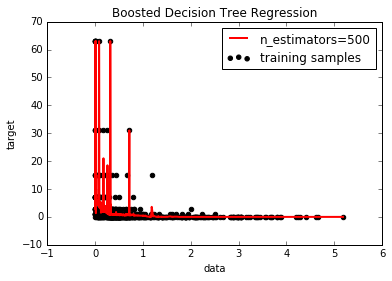

In [7]:
plt.figure()
px, py = zip(*sorted(zip(X['norm_rank'], y)))
plt.scatter(px, py, c="k", label="training samples")
px, py_1 = zip(*sorted(zip(X['norm_rank'], pred_y)))
plt.plot(px, py_1, c="r", label="n_estimators=500", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()

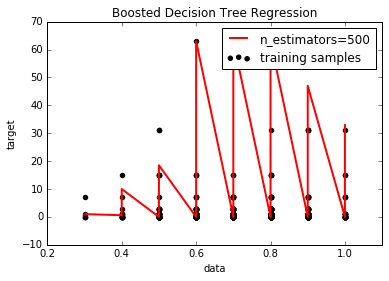

In [8]:
plt.figure()
px, py = zip(*sorted(zip(X['streak'], y)))
plt.scatter(px, py, c="k", label="training samples")
px, py_1 = zip(*sorted(zip(X['streak'], pred_y)))
plt.plot(px, py_1, c="r", label="n_estimators=500", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()

0.945807619722384

In [36]:
alpha = 0.5
beta = 0.05

for season in range(2010, 2017+1):
    for i in range(20):
        w = streak[(streak['Season'] == season) & (streak['StreakLen'] == 6)] \
            .merge(polls[['TeamID', 'Season', 'norm_rank', 'noise']], on=['Season', 'TeamID'], how='left') \
            .sort_values('norm_rank')

        w['combined_rank'] = w['norm_rank'] - alpha*w['streak'] + beta*(numpy.random.random(w.shape[0]) - 0.5)
        w[['TeamID', 'combined_rank']]

        bracket_file_name = 'bracket.combined.{}.{}.csv'.format(season, i)

        w[['TeamID', 'combined_rank']].to_csv(bracket_file_name, header=False, sep=' ', index=False)